In [376]:
#####Von Mises Regression model#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import math
from scipy import sparse
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize
import seaborn as sns
import time

#np.random.seed(98537)

In [377]:
####データの発生####
##データの設定
k = 10
N = 100000

##説明変数の生成
k1 = 4; k2 = 5; k3 = 6
x1 = np.array(np.random.random(N*k1)).reshape((N, k1))
x2 = np.zeros((N, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    x2[:, j] = np.random.binomial(1, prob, N)
x3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), N)
x3 = np.delete(x3, np.argmin(np.sum(x3, axis=0)), axis=1)   #冗長な変数の削除
x = np.concatenate((np.repeat(1, N)[:, np.newaxis], x1, x2, x3), axis=1)
k = x.shape[1]

(array([ 9692.,  3415.,  2370.,  2829.,  3604.,  5320.,  9099., 16848.,
        25206., 21617.]),
 array([-3.14157797e+00, -2.51327112e+00, -1.88496427e+00, -1.25665742e+00,
        -6.28350572e-01, -4.37240225e-05,  6.28263124e-01,  1.25656997e+00,
         1.88487682e+00,  2.51318367e+00,  3.14149052e+00]),
 <a list of 10 Patch objects>)

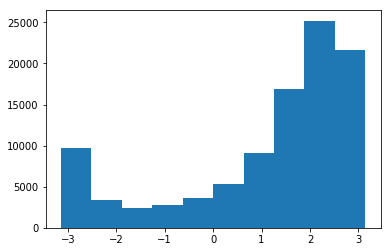

In [378]:
##応答変数の生成
#パラメータの設定
beta0 = np.random.uniform(0.75, 1.5, 1)
beta1 = np.random.normal(0, 1.0, k-1)
beta = np.append(beta0, beta1)
kappa = np.random.uniform(2.0, 4.0, 1)
betat = beta.copy(); kappat = kappa.copy()

#フォンミーゼス分布から円周データを生成
mu = 2*np.arctan(np.dot(x, beta))
y = np.random.vonmises(mu, kappa, N)
plt.hist(y)

In [379]:
##Von Mises Regression modelの対数尤度
def loglike(theta, y, x, N, index1, index2):
    #パラメータの設定
    beta = theta[index1]
    kappa = np.exp(theta[index2])
    
    #対数尤度の和を計算
    mu = 2*np.arctan(np.dot(x, beta))
    LL = -N*np.log(scipy.special.i0(kappa)) + kappa*np.sum(np.cos(y - mu))
    return -LL 

In [380]:
##Von Mises Regression modelの対数尤度の勾配ベクトル

In [394]:
##準ニュートン法で対数尤度を最大化
#初期値の設定
index1 = np.arange(k); index2 = k
beta = np.append(0.5, np.random.normal(0, 0.25, k-1))
kappa = 0
theta = np.append(beta, kappa)

#対数尤度を最大化
res = optimize.minimize(loglike, theta, method='BFGS', args=(y, x, N, index1, index2), 
                        options={"gtol": 0.01, "disp":True})

Optimization terminated successfully.
         Current function value: -73806.397606
         Iterations: 33
         Function evaluations: 864
         Gradient evaluations: 48


In [395]:
print(res.x[index1])
print(betat)
print(np.exp(res.x[index2]))
print(kappat)

[ 1.45601866  0.76571542 -1.17618286 -1.60120526  1.30148079  0.07800595
 -1.01885023  0.90881453  2.13647734  0.0212434  -0.5632592  -0.56690934
  1.9049217   0.63350419 -1.15863229]
[ 1.44138622  0.76816716 -1.18072986 -1.60463719  1.30894656  0.08124578
 -1.0291806   0.91693298  2.14105528  0.02433243 -0.54966174 -0.55356423
  1.92029365  0.63971983 -1.13864078]
2.561095058077224
[2.55844223]


[ 1.18604004  0.4837852  -0.08940134  0.8114682   0.24221025 -0.2620939
  0.53191566 -0.03248157  1.75513907 -0.47691409 -0.60295758  1.05240516
 -0.43677089 -0.96910883  0.21788241]
[ 1.20214975  0.48112283 -0.09204481  0.81197168  0.22835721 -0.26704226
  0.53320022 -0.02171317  1.76587361 -0.47162176 -0.60579553  0.95355996
 -0.44226209 -0.98248234  0.18541011]


2.0944404670174763
[2.08368612]


In [332]:
res1.x[index2]

2.0944399561820006

array([2.19598361, 0.95514365, 2.16654214, ..., 3.03020552, 2.28513358,
       2.02164439])